## Implementing Trading with Machine Learning LSTM
This notebook will create signals and compare strategy returns over GLD returns.
![image.png](https://d2a032ejo53cab.cloudfront.net/Glossary/xX83CP3F/p-3.drawio.png)

This notebook will generate a trading strategy using the high, and low prices predicted. Following this, we will study the strategy performance.
The key steps are:
1. [Import the Data](#import)
2. [Signal Generation](#returns)
3. [Plotting GLD Returns and Strategy Returns](#plot)

In [3]:
import math
import pandas_datareader as webA
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


# Data manipulation

# Machine learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#Binance
import os
from time import sleep
import asyncio

!pip install python-binance mplfinance

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
import pandas as pd

#env
from dotenv import load_dotenv
load_dotenv()

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

import asyncio

#For strategy analysis
import pyfolio as pf
# To ignore unwanted warnings
import warnings
warnings.filterwarnings("ignore")

You should consider upgrading via the 'C:\Users\John Jairo PC\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


c:\Users\John Jairo PC\AppData\Local\Programs\Python\Python310\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


<a id='import'></a>
## Import the Data
We import the `test_dataset_pred_high_low.csv`. It has gold prices data with predicted high and predicted low values calculated using the linear regression model.

In [4]:
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
import pandas as pd

In [5]:
apikey='ftrSLs5aVqS3N0MGpVJooDZK5DrJOHPDD5aOAd9UQvoYbGKIkVZ9N6dWmmq8DVzHe'
secret='pMKLNZwLDkYoihEq8CvtIgajXODl6KqlWzU2TsmDSzNGvDmOBvVwkUiGiOpZyVaN'

In [6]:
client = Client(apikey, secret)
tickers = client.get_all_tickers()
tickers

[{'symbol': 'ETHBTC', 'price': '0.07705700'},
 {'symbol': 'LTCBTC', 'price': '0.00466600'},
 {'symbol': 'BNBBTC', 'price': '0.01593500'},
 {'symbol': 'NEOBTC', 'price': '0.00039200'},
 {'symbol': 'QTUMETH', 'price': '0.00156300'},
 {'symbol': 'EOSETH', 'price': '0.00070600'},
 {'symbol': 'SNTETH', 'price': '0.00001580'},
 {'symbol': 'BNTETH', 'price': '0.00027000'},
 {'symbol': 'BCCBTC', 'price': '0.07908100'},
 {'symbol': 'GASBTC', 'price': '0.00012310'},
 {'symbol': 'BNBETH', 'price': '0.20680000'},
 {'symbol': 'BTCUSDT', 'price': '17276.10000000'},
 {'symbol': 'ETHUSDT', 'price': '1331.14000000'},
 {'symbol': 'HSRBTC', 'price': '0.00041400'},
 {'symbol': 'OAXETH', 'price': '0.00017780'},
 {'symbol': 'DNTETH', 'price': '0.00002801'},
 {'symbol': 'MCOETH', 'price': '0.00577200'},
 {'symbol': 'ICNETH', 'price': '0.00166300'},
 {'symbol': 'MCOBTC', 'price': '0.00021140'},
 {'symbol': 'WTCBTC', 'price': '0.00001137'},
 {'symbol': 'WTCETH', 'price': '0.00023700'},
 {'symbol': 'LRCBTC', 'p

In [7]:
tickers[1]['price']
ticker_df = pd.DataFrame(tickers)
ticker_df.head()

,symbol,price
0,ETHBTC,0.07705700
1,LTCBTC,0.00466600
2,BNBBTC,0.01593500
3,NEOBTC,0.00039200
4,QTUMETH,0.00156300


In [8]:
ticker_df.set_index('symbol', inplace=True)
float(ticker_df.loc['BTCUSDT']['price'])

17276.1

In [9]:
depth = client.get_order_book(symbol='BTCUSDT')
depth

{'lastUpdateId': 30298721808,
 'bids': [['17276.19000000', '0.00200000'],
  ['17276.18000000', '0.05035000'],
  ['17276.07000000', '0.02940000'],
  ['17276.06000000', '0.00400000'],
  ['17276.05000000', '0.00200000'],
  ['17276.04000000', '0.10800000'],
  ['17276.02000000', '0.09223000'],
  ['17275.95000000', '0.27781000'],
  ['17275.92000000', '0.20232000'],
  ['17275.91000000', '0.12335000'],
  ['17275.90000000', '0.08505000'],
  ['17275.88000000', '0.02000000'],
  ['17275.86000000', '0.04639000'],
  ['17275.85000000', '0.13578000'],
  ['17275.83000000', '0.00868000'],
  ['17275.82000000', '0.00982000'],
  ['17275.81000000', '0.35687000'],
  ['17275.78000000', '0.29843000'],
  ['17275.74000000', '0.02335000'],
  ['17275.71000000', '0.00660000'],
  ['17275.70000000', '0.01852000'],
  ['17275.57000000', '0.02563000'],
  ['17275.55000000', '0.00891000'],
  ['17275.54000000', '0.06583000'],
  ['17275.53000000', '0.19813000'],
  ['17275.52000000', '0.06518000'],
  ['17275.51000000', '0.12

In [10]:
historical = client.get_historical_klines('BTCUSDT', Client.KLINE_INTERVAL_1DAY, '1 Jan 2011')
hist_df = pd.DataFrame(historical)
hist_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1502928000000,4261.48000000,4485.39000000,4200.74000000,4285.08000000,795.15037700,1503014399999,3454770.05073206,3427,616.24854100,2678216.40060401,0
1,1503014400000,4285.08000000,4371.52000000,3938.77000000,4108.37000000,1199.88826400,1503100799999,5086958.30617151,5233,972.86871000,4129123.31651808,0
2,1503100800000,4108.37000000,4184.69000000,3850.00000000,4139.98000000,381.30976300,1503187199999,1549483.73542151,2153,274.33604200,1118001.87008735,0
3,1503187200000,4120.98000000,4211.08000000,4032.62000000,4086.29000000,467.08302200,1503273599999,1930364.39032646,2321,376.79594700,1557401.33373730,0
4,1503273600000,4069.13000000,4119.62000000,3911.79000000,4016.00000000,691.74306000,1503359999999,2797231.71402728,3972,557.35610700,2255662.55315837,0


In [11]:
hist_df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 
                    'Number of Trades', 'TB Base Volume', 'TB Quote Volume', 'Ignore']
#hist_df.set_index('Open Time')
hist_df.tail()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,Ignore
1968,1672963200000,16831.85000000,17041.00000000,16679.00000000,16950.65000000,207401.28415000,1673049599999,3490305009.68812240,5388661,103320.22965000,1738828235.20230050,0
1969,1673049600000,16950.31000000,16981.91000000,16908.00000000,16943.57000000,104526.56880000,1673135999999,1770201710.20897340,3227161,51624.83107000,874295207.63651240,0
1970,1673136000000,16943.83000000,17176.99000000,16911.00000000,17127.83000000,135155.89695000,1673222399999,2291925699.95854550,4036092,67200.60250000,1139647002.76085130,0
1971,1673222400000,17127.83000000,17398.80000000,17104.66000000,17178.26000000,266211.52723000,1673308799999,4590284350.54616930,6327667,131748.52517000,2271681164.79933240,0
1972,1673308800000,17179.04000000,17326.07000000,17146.34000000,17279.04000000,124685.47241000,1673395199999,2148274582.72337410,3061720,61199.55415000,1054445883.24321410,0


In [12]:
hist_df['Open Time'] = pd.to_datetime(hist_df['Open Time']/1000, unit='s')
hist_df['Close Time'] = pd.to_datetime(hist_df['Close Time']/1000, unit='s')

In [13]:
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume']

In [14]:
hist_df[numeric_columns] = hist_df[numeric_columns].apply(pd.to_numeric, axis=1)

In [15]:
crypto_price=hist_df.drop(columns=[ 'Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume', 'Ignore', 'Number of Trades','Close Time' ])
cp=crypto_price.set_index('Open Time')
cp.tail()


,Open,High,Low,Close,Volume
Open Time,,,,,
2023-01-06,16831.85,17041.00,16679.00,16950.65,207401.28415
2023-01-07,16950.31,16981.91,16908.00,16943.57,104526.56880
2023-01-08,16943.83,17176.99,16911.00,17127.83,135155.89695
2023-01-09,17127.83,17398.80,17104.66,17178.26,266211.52723
2023-01-10,17179.04,17326.07,17146.34,17279.04,124685.47241


In [16]:
data = cp.filter(['Open', 'High', 'Low', 'Close',])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8) # We are using %80 of the data for training
training_data_len
dataset.shape

#, 'High', 'Low', 'Open'

(1973, 4)

In [17]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data.shape

(1973, 4)

In [18]:
# Creat the training dataset
train_data = scaled_data[0:training_data_len, :]
# Split the data into X_train and y_train data sets
X_train = []
y_train = []

for i in range(60, len(train_data)):
  X_train.append(train_data[i-60: i, 0])
  y_train.append(train_data[i, 0])


  if i <= 60:
    print(X_train)
    print(y_train)
    print()



[array([0.0166849 , 0.01705172, 0.01430512, 0.01450112, 0.01369521,
       0.01286942, 0.01324245, 0.01490554, 0.01753246, 0.01698379,
       0.01778892, 0.0174392 , 0.0181175 , 0.02139504, 0.02124925,
       0.02334366, 0.02499541, 0.02052432, 0.02046992, 0.01428336,
       0.01831707, 0.02225379, 0.02337117, 0.01701628, 0.0166434 ,
       0.01500844, 0.01586299, 0.01510325, 0.01175032, 0.        ,
       0.00755388, 0.00772827, 0.00780241, 0.01355331, 0.01122248,
       0.01091085, 0.00629226, 0.00633951, 0.00919413, 0.00733643,
       0.01150163, 0.01079225, 0.01560669, 0.01540261, 0.01534075,
       0.01850358, 0.01883791, 0.01852705, 0.01751521, 0.01586283,
       0.01757878, 0.01835608, 0.01922649, 0.02256822, 0.02485226,
       0.0247918 , 0.02538818, 0.03500243, 0.03826661, 0.04145338])]
[0.039199189403556]



In [19]:
len(X_train)
# Convert the X_train and y_train to numpy array
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape


(1519, 60)

In [20]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # we make it like pros. it wanna say "np.reshape(X_train, (2083, 60, 1))"
X_train.shape


(1519, 60, 1)

In [21]:
# Create the testing dataset
# Create a new array containing scaled values from index 2083
test_data = scaled_data[training_data_len - 60 : , :]

#Create the data sets X_test and y_test
X_test = []
y_test = dataset[training_data_len : , :]
for i in range(60, len(test_data)):
  X_test.append(test_data[i-60 : i, 0])

In [22]:
# Convert the data to a numpy array 
X_test = np.array(X_test)

In [23]:
# Reshape the test data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [24]:
# Build LSTM model
tf.random.set_seed(42)

model_1 = Sequential()
model_1.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # we made it like pros ;) , the simple form is "input_shape(60, 1)""
model_1.add(LSTM(50, return_sequences=False))
model_1.add(Dense(25))
model_1.add(Dense(1))


In [25]:
# Compile the model
model_1.compile(optimizer='adam', loss='mse')

In [26]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model_1.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10


In [ ]:
# Get the model_1 predicted price values 
predictions_1 = model_1.predict(X_test)
predictions_1 = scaler.inverse_transform(predictions_1)
len(predictions_1)

13/13 [==============================] - 2s 14ms/step


ValueError: non-broadcastable output operand with shape (394,1) doesn't match the broadcast shape (394,4)

In [ ]:
# Get the root mean squared error (RMSE) for model_1
rmse = np.sqrt(np.mean(predictions_1 - y_test)**2)
rmse

284.0475089229062

Text(0.5, 0, 'epochs')

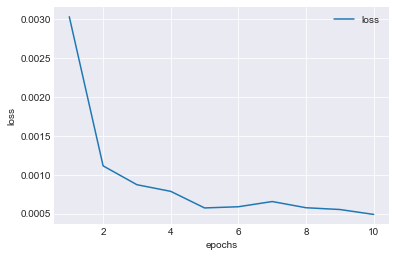

In [ ]:
# Let's plot the history of model_1 and see what's going on
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")



In [ ]:
# Train the model again with 7 epochs
# but first we need to create another model so we can compare them together

# building LSTM model_2
tf.random.set_seed(42)

model_2 = Sequential()
model_2.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # we made it like pros ;) | the simple form is "input_shape(60, 1)
model_2.add(LSTM(50, return_sequences=False))
model_2.add(Dense(25))
model_2.add(Dense(1))

# Compile model_2
model_2.compile(optimizer='Adam', loss='mse')

# Fit model_2
history_2 = model_2.fit(X_train, y_train, batch_size=1, epochs=6)

Epoch 1/6
1517/1517 [==============================] - 32s 20ms/step - loss: 0.0030
Epoch 2/6
1517/1517 [==============================] - 32s 21ms/step - loss: 0.0011
Epoch 3/6
1517/1517 [==============================] - 35s 23ms/step - loss: 8.4569e-04
Epoch 4/6
1517/1517 [==============================] - 35s 23ms/step - loss: 8.4989e-04
Epoch 5/6
1517/1517 [==============================] - 39s 26ms/step - loss: 5.6921e-04
Epoch 6/6
1517/1517 [==============================] - 41s 27ms/step - loss: 5.8989e-04


In [ ]:
# Get the model_2 predicted price values 
predictions_2 = model_2.predict(X_test)
predictions_2 = scaler.inverse_transform(predictions_2)
len(predictions_2)

13/13 [==============================] - 1s 18ms/step


394

In [ ]:
# Get the root mean squared error (RMSE) for model_2
rmse_2 = np.sqrt(np.mean(predictions_2 - y_test)**2)
rmse_2

533.7972820828045

,Close
Open Time,
2021-12-06,50441.92
2021-12-07,50588.95
2021-12-08,50471.19
2021-12-09,47545.59
2021-12-10,47140.54


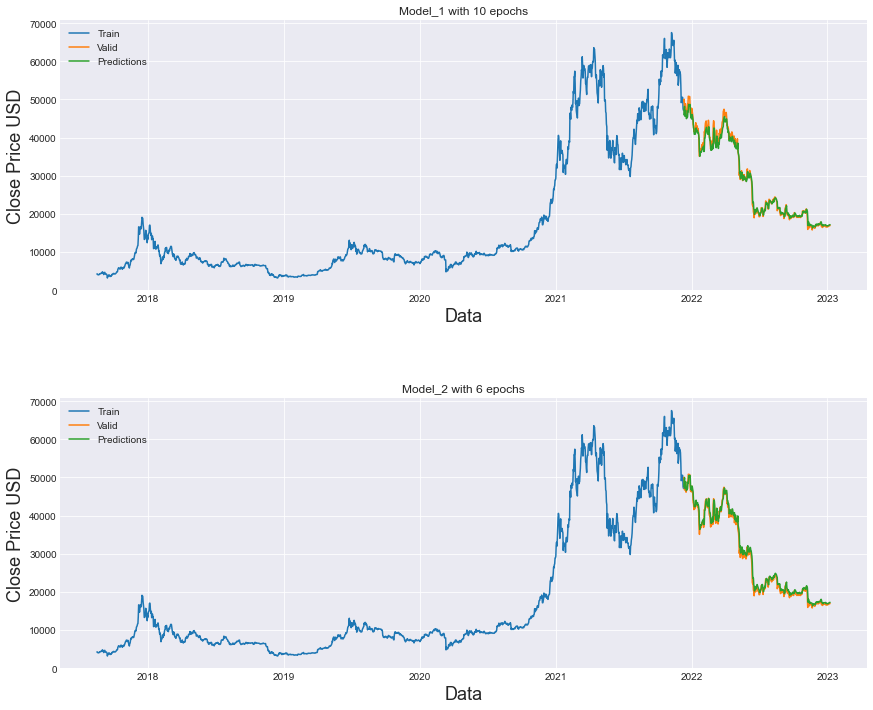

In [ ]:
# Plot the data
train = data[:training_data_len]

#data for model_1
valid_1 = data[training_data_len:]
valid_1['Predictions'] = predictions_1

# data for model_2
valid_2 = data[training_data_len:]
valid_2['Predictions'] = predictions_2

# Visualized the data 
#model_1
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title('Model_1 with 10 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid_1[['Close', 'Predictions']])

plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

#model_2
plt.subplot(2, 1, 2)
plt.title('Model_2 with 6 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid_2[['Close', 'Predictions']])

plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [ ]:
valid_1.tail()

,Close,Predictions
Open Time,,
2023-01-04,16850.36,16938.363281
2023-01-05,16831.85,17072.904297
2023-01-06,16950.65,17071.474609
2023-01-07,16943.57,17165.880859
2023-01-08,16929.24,17170.328125


In [ ]:
valid_2.tail()

,Close,Predictions
Open Time,,
2023-01-04,16850.36,16999.265625
2023-01-05,16831.85,17131.810547
2023-01-06,16950.65,17144.121094
2023-01-07,16943.57,17238.302734
2023-01-08,16929.24,17254.109375
